In [1]:
pip install pandas_datareader


In [2]:
from keras.preprocessing.sequence import TimeseriesGenerator
import datetime as dt, pandas_datareader
import pandas as pd
import numpy as np
from pandas_datareader import data
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import SimpleRNN
import yfinance as yf

In [3]:
symbol = 'BTC-USD'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime.now()

In [4]:
df = yf.download(symbol, start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


In [5]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [6]:
Data = df["Close"]
Data = pd.DataFrame(Data)
print(type(Data))
Data.head(5)

<class 'pandas.core.frame.DataFrame'>


,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [9]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaledData = scaler.fit_transform(Data)

In [10]:
len(df)

3362

In [11]:
train = scaledData[:2700]
validation = scaledData[2700:2900]
test = scaledData[2900:]

In [12]:
print(train.shape)
print(validation.shape)
print(test.shape)


(2700, 1)
(200, 1)
(462, 1)


In [13]:
trainGen = TimeseriesGenerator(data=train,targets=train,length=2,
                              sampling_rate=1,stride=1,
                              shuffle=False,reverse=False,
                              batch_size=8)
valGen = TimeseriesGenerator(data=validation,targets=validation,length=2,
                              sampling_rate=1,stride=1,
                              shuffle=False,reverse=False,
                              batch_size=8)
testGen = TimeseriesGenerator(data=test,targets=test,length=2,
                              sampling_rate=1,stride=1,
                              shuffle=False,reverse=False,
                              batch_size=8)

In [14]:
BTC = Sequential()
BTC.add(LSTM(32,return_sequences=False, input_shape=(2,1)))
BTC.add(Dense(1))
print(BTC.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
BTC.compile(loss='mean_absolute_error',optimizer='adam',metrics=['mae','mse'])
history = BTC.fit_generator(trainGen,validation_data=valGen,
                   epochs=50,verbose = 1)

<ipython-input-15-e9e194ad175a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = BTC.fit_generator(trainGen,validation_data=valGen,


Epoch 1/50
338/338 [==============================] - 8s 8ms/step - loss: 0.0540 - mae: 0.0540 - mse: 0.0156 - val_loss: 0.0162 - val_mae: 0.0162 - val_mse: 4.5658e-04
Epoch 2/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0084 - mae: 0.0084 - mse: 2.7449e-04 - val_loss: 0.0165 - val_mae: 0.0165 - val_mse: 4.7603e-04
Epoch 3/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0074 - mae: 0.0074 - mse: 2.1543e-04 - val_loss: 0.0171 - val_mae: 0.0171 - val_mse: 5.2776e-04
Epoch 4/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0069 - mae: 0.0069 - mse: 1.9982e-04 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 8.5710e-04
Epoch 5/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0074 - mae: 0.0074 - mse: 2.0114e-04 - val_loss: 0.0154 - val_mae: 0.0154 - val_mse: 4.4586e-04
Epoch 6/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0077 - mae: 0.0077 - mse: 2.3979e-04 - val_loss: 0.0148 - val_mae: 0

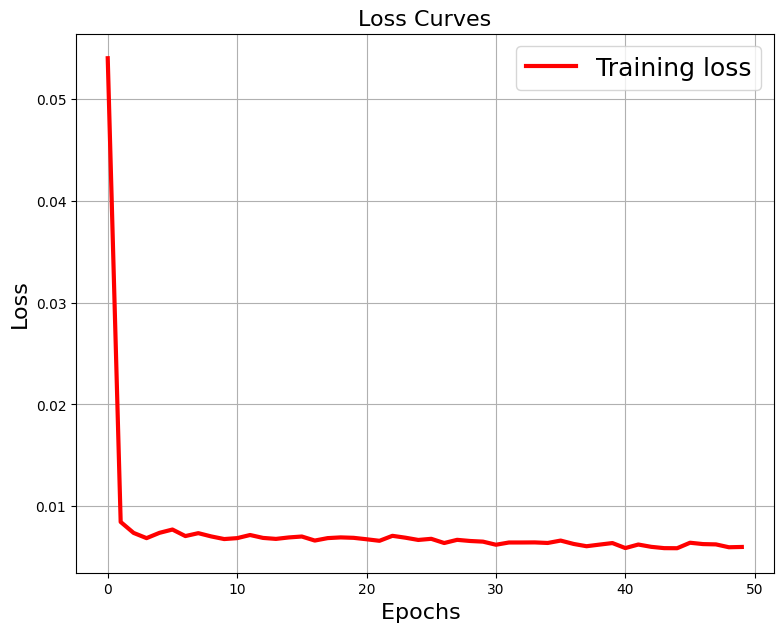

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[9,7])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.grid(True)

In [18]:
predictions = BTC.predict_generator(testGen)
predictions = scaler.inverse_transform(predictions)
test = scaler.inverse_transform(test)


<ipython-input-18-aa0502828116>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = BTC.predict_generator(testGen)


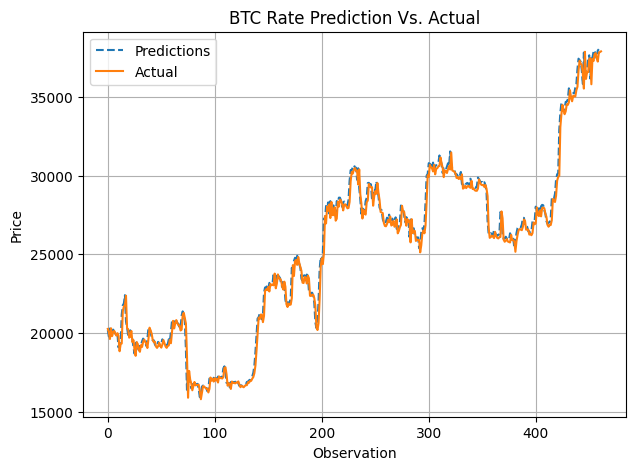

In [19]:
plt.figure(figsize=[7,5])
plt.plot(predictions,'--',label='Predictions')
plt.plot(test,label='Actual')
plt.xlabel("Observation")
plt.ylabel("Price")
plt.title("BTC Rate Prediction Vs. Actual")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
PresentRate = df["Close"].iloc[-1]

In [21]:
print(PresentRate)

37904.71484375


In [22]:
PredictedRate = predictions[-1][0]

In [23]:
print(PredictedRate)

38042.047


In [24]:
if PredictedRate > PresentRate:
  print("It is recommended to buy crypto.")
elif PredictedRate< PresentRate:
  print("It is not recommended to buy crypto. It is recommended to sell your crypto.")
else:
  print("The predicted rate is similar to the present rate. Consider holding your crypto")

It is recommended to buy crypto.
